# Land Mask

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
from salishsea_tools import viz_tools
from salishsea_tools import geo_tools
from salishsea_tools import grid_tools
from salishsea_tools import utilities
%matplotlib inline

In [18]:
GEM = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1")  # HDPRC latlon
nemo_mask =xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02") # NEMO land mask
nemo_grid = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02") # NEMO lat lon

In [135]:
winddata = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1") # Contains wind data

In [42]:
def build_GEM_mask(grid_GEM, grid_NEMO, mask_NEMO):


    # Preallocate
    ngrid_GEM = grid_GEM['gridX'].shape[0] * grid_GEM['gridY'].shape[0]
    mask_GEM = np.zeros(ngrid_GEM, dtype=int)

    # Evaluate each point on GEM grid
    bar = utilities.statusbar('Building GEM mask', width=90, maxval=ngrid_GEM)
    for index, coords in enumerate(bar(zip(
            grid_GEM['longitude'].values.reshape(ngrid_GEM) - 360,
            grid_GEM['latitude'].values.reshape(ngrid_GEM),
    ))):

        j, i = geo_tools.find_closest_model_point(
            coords[0], coords[1],
            grid_NEMO['longitude'], grid_NEMO['latitude'],
        )
        if j is np.nan or i is np.nan:
            mask_GEM[index] = 0
        else:
            mask_GEM[index] = mask_NEMO[j, i].values

    # Reshape
    mask_GEM = mask_GEM.reshape(grid_GEM['longitude'].shape)

    return mask_GEM

In [94]:
land_mask = build_GEM_mask(GEM, nemo_grid, nemo_mask.tmaskutil.isel(time=0))

Building GEM mask 100% (68096 of 68096) |##################################|Time:  0:04:15


In [117]:
def mask_data(data): # Attempt at creating mask function
    return data.where(land_mask == 0, drop = True)

In [136]:
masked_wind_data = winddata.u_wind.isel(time=0) * land_mask  # Example of masked data

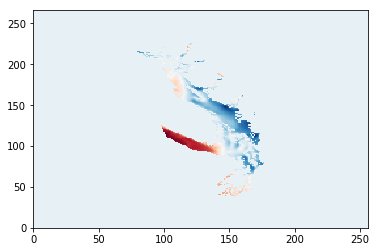

In [137]:
plt.pcolormesh(masked_wind_data, cmap = 'RdBu') # plot of example masked data